# Trabajo sobre cartogramas

La idea es crear un cartograma a partir de un mapa de límites. Por ejemplo, a partir de los 9 departamentos de Bolivia, crear una agrupación de nueve cuadrados de mismo tamaño, pero colocados de forma a respetar más o menos la forma de Bolivia. Y luego, con colores, se puede representar cualquier tipo de valor: porcentaje en una elección, población, etc.

La entrada es un GML de polígonos. Por ejemplo, haremos con los departamentos de Bolivia, fuente: https://geo.gob.bo/geoserver/georchestra/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=georchestra:departamento&maxFeatures=50.

Lo cargamos (archivo `departamentos.gml` guardado a la raíz de este notebook) y lo visualizamos como mapa, utilizando GeoPandas.

Importamos geopandas

In [1]:
import geopandas as gpd

Descargamos la capa en formato GeoJSON a la raíz de este notebook:

```
curl -o departamentos.json "https://geo.gob.bo/geoserver/georchestra/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=georchestra:departamento&maxFeatures=50&outputFormat=application%2Fjson"
```

El archivo de datos está en "departamentos.json"

In [2]:
archivo = "departamentos.json"

Lo cargamos y mostramos su contenido

In [3]:
departamentos = gpd.read_file(archivo)
departamentos.head(10)

,id,nombre,geometry
0,departamento.1,BENI,(POLYGON ((-7237869.856431061 -1333098.7996114...
1,departamento.2,CHUQUISACA,(POLYGON ((-7161107.062878479 -2115498.0238916...
2,departamento.3,COCHABAMBA,(POLYGON ((-7359077.251790833 -2014293.7788348...
3,departamento.4,LA PAZ,(POLYGON ((-7445856.570898612 -1792340.5311615...
4,departamento.5,ORURO,(POLYGON ((-7615011.600303391 -2204420.2513557...
5,departamento.6,PANDO,(POLYGON ((-7478996.498634759 -1157053.9389695...
6,departamento.7,POTOSI,(POLYGON ((-7533467.561929605 -2232891.0721299...
7,departamento.8,SANTA CRUZ,(POLYGON ((-6623013.894983889 -1837418.6859583...
8,departamento.9,TARIJA,(POLYGON ((-7142292.53840274 -2378559.65273468...


Lo mostramos en el mapa

In [4]:
departamentos = departamentos.set_geometry('geometry')
departamentos.plot();

En este trabajo, en realidad, solo nos interesa los centroides de los polígonos. Los calculamos:

In [5]:
departamentos['centroides'] = departamentos.centroid
departamentos = departamentos.set_geometry('centroides')
departamentos.head(10)

,id,nombre,geometry,centroides
0,departamento.1,BENI,(POLYGON ((-7237869.856431061 -1333098.7996114...,POINT (-7266219.907314875 -1546680.683465938)
1,departamento.2,CHUQUISACA,(POLYGON ((-7161107.062878479 -2115498.0238916...,POINT (-7156244.216767156 -2279156.435748333)
2,departamento.3,COCHABAMBA,(POLYGON ((-7359077.251790833 -2014293.7788348...,POINT (-7304679.772668183 -1942393.680851367)
3,departamento.4,LA PAZ,(POLYGON ((-7445856.570898612 -1792340.5311615...,POINT (-7584149.089937904 -1718207.239816681)
4,departamento.5,ORURO,(POLYGON ((-7615011.600303391 -2204420.2513557...,POINT (-7535607.541595574 -2112200.593445688)
5,departamento.6,PANDO,(POLYGON ((-7478996.498634759 -1157053.9389695...,POINT (-7495050.588464576 -1243209.84835299)
6,departamento.7,POTOSI,(POLYGON ((-7533467.561929605 -2232891.0721299...,POINT (-7428529.754223818 -2339339.620883689)
7,departamento.8,SANTA CRUZ,(POLYGON ((-6623013.894983889 -1837418.6859583...,POINT (-6848377.420853903 -1948450.710741088)
8,departamento.9,TARIJA,(POLYGON ((-7142292.53840274 -2378559.65273468...,POINT (-7111180.6895021 -2463392.971836333)


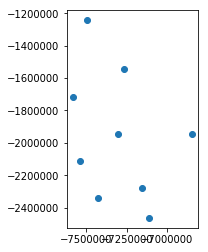

In [6]:
departamentos.plot();

Ahora nos interesa calcular, entre dos puntos, la distancia en km, y el ángulo con la línea horizontal hacia el este del primer punto. Por ejemplo, para La Paz hacia Trinidad, la distancia se calcula así:

In [7]:
print(f'Distancia: {departamentos.centroides[3].distance(departamentos.centroides[0])} m')

Distancia: 361248.28677364247 m


Y el ángulo:

In [8]:
import math
def AnguloGeografico (p1, p2):
    x1 = p1.x
    y1 = p1.y
    x2 = p2.x
    y2 = p2.y
    dX = x2 - x1
    dY = y2 - y1
    rads = math.atan2 (dY, dX) #wrong for finding angle/declination?
    return math.degrees (rads)
print(f'Ángulo: {AnguloGeografico(departamentos.centroides[3],departamentos.centroides[0])}°')

Ángulo: 28.347386670666342°


Para definir de qué lado se debería encontrar el cuadrado de Beni en relación al cuadrado de La Paz en el cartograma, calculamos una "matriz" de pesos, que serán más altos si:

- el ángulo entre los cuadrados es cercano al ángulo entre los centroides: lo hacemos con un coseno de la diferencia entre ángulos,
- el cuadrado está más cerca, para favorecer un cartograma compacto: dividimos por la distancia entre los dos cuadrados,
- la distancia entre los centroides es más pequeña: dividimos por la distancia entre los dos centroides.

Cómo hay 8 ciudades, a parte de La Paz, haremos una "matriz" que va de -8 hasta +8, en x y y. Los centros de los cuadrados se encontrarán, por convención, en valores enteros: ...-3, -2, -1, 0, 1, 2, 3... La Paz, en este caso, estará en las coordenadas (0,0).

In [9]:
import numpy as np
dimension = len(departamentos) - 1
x = np.arange(-dimension,dimension+1)
y = x
m = np.zeros((len(x), len(y)))

def AnguloGeometrico (x1, y1, x2, y2):
    dX = x2 - x1
    dY = y2 - y1
    rads = math.atan2 (dY, dX) #wrong for finding angle/declination?
    return math.degrees (rads)

grados_lapaz_beni = AnguloGeografico(departamentos.centroides[3],departamentos.centroides[0])
distancia_lapaz_beni = departamentos.centroides[3].distance(departamentos.centroides[0])

for i in range(0, len(x)):
    for j in range(0, len(y)):
        angulo = AnguloGeometrico(0, 0, x[i], y[j])
        distancia = math.hypot(x[i], y[j])
        #print(f'x: {x[i]}, y: {y[j]}, Distancia: {distancia}, Ángulo: {angulo}')
        if (distancia == 0 or distancia_lapaz_beni == 0):
            peso = 0
        else:
            peso = math.cos(math.radians(grados_lapaz_beni - angulo)) / (distancia_lapaz_beni * distancia)
        # OjO: la primera dimensión es la vertical, la segunda es la horizontal
        m[j,i] = peso

Visualizamos la matriz de pesos para La Paz - Trinidad

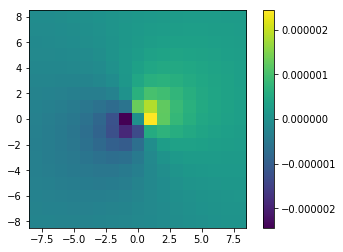

In [10]:
import matplotlib.pyplot as plt
plt.imshow(m, origin='lower', extent=[-dimension-0.5, dimension+0.5, -dimension-0.5, dimension+0.5])
plt.colorbar()

Claramente, se ve que la mejor ubicación para el cuadrado de Beni sería a la derecha del cuadrado de La Paz, la segunda mejor sería encima a la derecha de La Paz. La peor ubicación sería a la izquierda de La Paz

## Cartograma a partir de La Paz

Ahora que logramos encontrar la mejor ubicación para Beni y La Paz, probemos de encontrar la mejor ubicación para el cuadrado de cada departamento, utilizando La Paz como referencia. Para eso, necesitamos calcular la matriz de pesos para cada departamento, en relación con La Paz, y luego aplicaremos el algoritmo siguiente: se busca el mayor peso en todas las matrices, y el departamento que corresponde, así como la ubicación de este peso máximo, establecen la ubicación del departamente en el cartograma final. Luego, se cancela esta ubicación en todas las matrices, se descarta la matriz del departamente elegido, y se vuelve a hacer el mismo ejercicio. Lo mismo hasta haber agotado las matrices.

### Cálculo de todas las matrices

Establecemos la función para cálculo de una matriz:

In [11]:
# Calcula la matriz de pesos del punto k2, en función al punto k1 de referencia (La Paz)
def matriz_pesos(puntos, k1, k2):
    dimension = len(puntos) - 1
    x = np.arange(-dimension,dimension+1)
    y = x
    m = np.zeros((len(x), len(y)))

    angulo_geografico = AnguloGeografico(puntos.centroides[k1],puntos.centroides[k2])
    distancia_geografica = puntos.centroides[k1].distance(puntos.centroides[k2])

    for i in range(0, len(x)):
        for j in range(0, len(y)):
            angulo = AnguloGeometrico(0, 0, x[i], y[j])
            distancia = math.hypot(x[i], y[j])
            if (distancia == 0 or distancia_geografica == 0):
                peso = 0
            else:
                peso = math.cos(math.radians(angulo_geografico - angulo)) / (distancia_geografica * distancia)
            # OjO: la primera dimensión es la vertical, la segunda es la horizontal
            m[j,i] = peso
    return m

Calculamos todas las matrices

In [12]:
matrices = []
k_lapaz = 3
for k in range(0, len(departamentos)):
    if k == k_lapaz:
        m = []
    else:
        m = matriz_pesos(departamentos, k_lapaz, k)
    matrices.append(m)

Mostramos las matrices

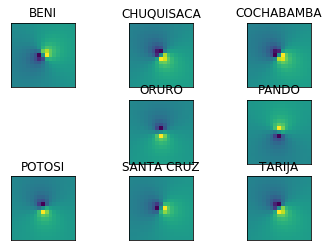

In [13]:
f, sp = plt.subplots(3, 3)
for k in range(0, len(departamentos)):
    idx = np.unravel_index(k, (3,3))
    if k == k_lapaz:
        sp[idx].set_visible(False)
        continue
    sp[idx].imshow(matrices[k], origin='lower', extent=[-dimension-0.5, dimension+0.5, -dimension-0.5, dimension+0.5])
    sp[idx].set_title(departamentos.nombre[k])
    sp[idx].get_xaxis().set_visible(False)
    sp[idx].get_yaxis().set_visible(False)

Aplicamos el algoritmo:

In [14]:
def calcular_cartograma(departamentos, k_departamento):
    # Matriz de resultado (cartograma)
    dimension = len(departamentos) - 1
    x = np.arange(-dimension,dimension+1)
    y = x
    cartograma = np.full((len(x), len(y)), np.nan)
    cartograma[dimension, dimension] = k_departamento
    
    matrices = []
    for k in range(0, len(departamentos)):
        if k == k_departamento:
            m = []
        else:
            m = matriz_pesos(departamentos, k_departamento, k)
        matrices.append(m)
    
    # Etapas del algoritmo
    for k1 in range(0, len(departamentos) - 1):
        # print(f'### Etapa {k1+1} / {len(departamentos)}')
        # Búsqueda del máximo
        k2_max = math.nan
        idx_max = math.nan
        valor_max = -math.inf
        for k2 in range(0, len(departamentos)):
            if len(matrices[k2]) == 0:
                continue
            idx = np.unravel_index(np.argmax(matrices[k2]), matrices[k2].shape)
            valor = matrices[k2][idx]
            # print(f' * departamento {departamentos.nombre[k2]} - valor max: {valor}')
            if valor > valor_max:
                idx_max = idx
                valor_max = valor
                k2_max = k2
        # Asignación departamento en el cartograma
        #print(f' -> departamento {k2_max} - {departamentos.nombre[k2_max]} - Ubicación: {(idx_max[0] - 8, idx_max[1]-8)}')
        cartograma[idx_max] = k2_max
        # Cancelar esta ubicación para todas las matrices
        for k2 in range(0, len(departamentos)):
            if len(matrices[k2]) == 0:
                continue
            matrices[k2][idx_max] = 0
        # Cancelar la matriz del departamento elegido
        matrices[k2_max] = []
    return cartograma

cartograma = calcular_cartograma(departamentos, 2)

Mostramos el cartograma obtenido:

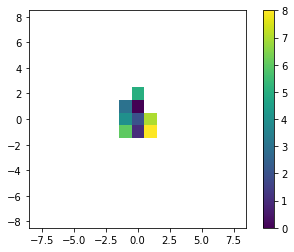

In [15]:
%matplotlib inline
plt.imshow(cartograma, origin='lower', extent=[-dimension-0.5, dimension+0.5, -dimension-0.5, dimension+0.5])
plt.colorbar()

Haremos una visualización más clara del cartograma, estilo http://blog.apps.npr.org/2015/05/11/hex-tile-maps.html.

<IPython.core.display.Javascript object>


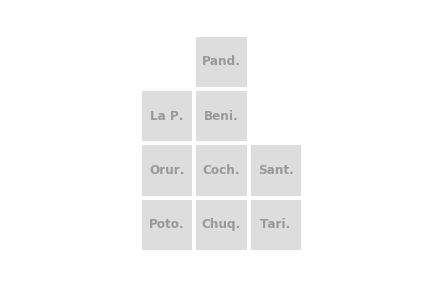

In [24]:
from matplotlib.patches import Rectangle

def visualizar_cartograma(cartograma, nombres):
    # Primero, hacemos un "zoom" sobre las casillas no vacias
    columnas_no_vacias = np.where(np.all(np.isnan(cartograma), 0) == False)[0]
    filas_no_vacias = np.where(np.all(np.isnan(cartograma), 1) == False)[0]
    cartograma_zoom = cartograma[min(filas_no_vacias):max(filas_no_vacias)+1,:][:,min(columnas_no_vacias):max(columnas_no_vacias)+1]
    # Dimensiones
    (num_filas, num_columnas) = cartograma_zoom.shape
    # Dibujar
    fig, ax = plt.subplots()
    for f in range(0, num_filas):
        for c in range(0, num_columnas):
            if np.isnan(cartograma_zoom[f, c]):
                continue
            nombre = nombres[cartograma_zoom[f, c]].title()[0:4] + '.'
            r = Rectangle((c, f), 1, 1, ec='#FFFFFF', fc='#DDDDDD', linewidth=4)
            ax.add_artist(r)
            rx, ry = r.get_xy()
            cx = rx + r.get_width()/2.0
            cy = ry + r.get_height()/2.0
            ax.annotate(nombre, (cx, cy), color='#999999', weight='bold', 
                        fontsize=12, ha='center', va='center')
    ax.set_xlim((0, num_columnas))
    ax.set_ylim((0, num_filas))
    ax.set_aspect('equal')
    plt.axis('off')
    plt.show()
            
            
visualizar_cartograma(cartograma, departamentos.nombre)

## Función de costo del cartograma

Primero, estableceremos la medición de la eficacia (función de costo) del cartograma: para cada departamento del cartograma, calcular el peso de cada uno de los otros departamentos en su ubicación del cartograma, y luego sumar todo.

In [20]:
def costo_cartograma(cartograma, puntos):
    # primero encontrar todos los elementos no vacios del cronograma
    indices = np.where(np.isfinite(cartograma))
    
    peso_total = 0
    # ahora, para cada par de indices, calcular el peso, y sumar todo
    # OjO: asumimos que es igual el número de casillas no NaN en cartograma que el número de puntos, habría que
    # manejar los casos de error
    for i in range(0, 1):#len(puntos)):
        for j in range(0, 2):#len(puntos)):
            if i == j:
                continue
            # Las coordenadas en el cartograma
            x1 = indices[0][i]
            y1 = indices[1][i]
            x2 = indices[0][j]
            y2 = indices[1][j]
            
            # Los indices de los departamentos
            k1 = cartograma[x1,y1]
            k2 = cartograma[x2,y2]
            #print(f'Departamento 1: {puntos.nombre[k1]}, Departamento 2: {puntos.nombre[k2]}')
            
            
            angulo_geografico = AnguloGeografico(puntos.centroides[k1],puntos.centroides[k2])
            #print(f'Angulo geográfico: {angulo_geografico}°')
            distancia_geografica = puntos.centroides[k1].distance(puntos.centroides[k2])
            #print(f'Distancia geográfica: {distancia_geografica}m')

            angulo = AnguloGeometrico(y1, x1, y2, x2)           
            #print(f'Angulo geométrico: {angulo}°')
            distancia = math.hypot(y2-y1, x2-x1)
            #print(f'Distancia geométrica: {distancia}')
            if (distancia == 0 or distancia_geografica == 0):
                peso = 0
            else:
                peso = math.cos(math.radians(angulo_geografico - angulo)) / (distancia_geografica * distancia)
            peso_total += peso
    return peso_total

print(f'Costo del cartograma con referencia La Paz: {costo_cartograma(cartograma, departamentos)}')


Costo del cartograma con referencia La Paz: 3.5015500431680274e-06


## 9 cartogramas


Ahora, probamos lo mismo, pero con cada uno de los departamentos como departamento de referencia

<IPython.core.display.Javascript object>


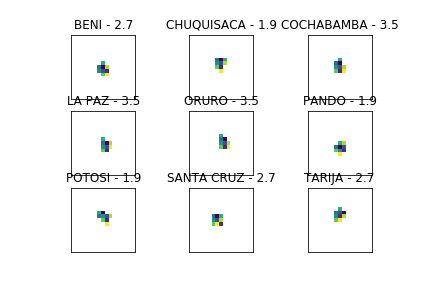

In [22]:
%matplotlib notebook

pesos = []

cartogramas = []
f, sp = plt.subplots(3, 3)
for k in range(0, len(departamentos)):
    cartogramas.append(calcular_cartograma(departamentos, k))
    pesos.append(costo_cartograma(cartogramas[k], departamentos))
    
    idx = np.unravel_index(k, (3,3))
    sp[idx].imshow(cartogramas[k], origin='lower', extent=[-dimension-0.5, dimension+0.5, -dimension-0.5, dimension+0.5])
    sp[idx].set_title(f'{departamentos.nombre[k]} - {round(pesos[k]*1000000,1)}')
    sp[idx].get_xaxis().set_visible(False)
    sp[idx].get_yaxis().set_visible(False)

Vemos que son bien diferentes uno del otro. Por lo que hay que hacer un trabajo adicional para mezclarlos y obtener el mejor cartograma, como un promedio de estos 9. Se puede ver que los cartogramas calculados desde La Paz, Oruro, o Cochabamba son muy parecidos, solo varian de un punto, y tienen los valores más alto de la función de costo. Son los que mejor representan la forma de Bolivia también, así que estamos por buen camino.

# Con las provincias de Bolivia

Probaremos ahora con las provincias de Bolivia:
    
```
curl -o provincias.json "https://geo.gob.bo/geoserver/georchestra/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=georchestra:provincia&maxFeatures=500&outputFormat=application%2Fjson"
```

In [ ]:
archivo = "provincias.json"
provincias = gpd.read_file(archivo)
provincias['centroides'] = provincias.centroid
provincias = provincias.set_geometry('centroides')
dimension = len(provincias) - 1

c = calcular_cartograma(provincias, 0)
p = costo_cartograma(c, provincias)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(c, origin='lower', extent=[-dimension-0.5, dimension+0.5, -dimension-0.5, dimension+0.5])
ax.set_title(f'{provincias.nombre[0]} - {round(p*1000000,1)}')


# Con los municipios de Bolivia

Probaremos ahora con los municipios de Bolivia:
    
```
curl -o municipios.json "https://geo.gob.bo/geoserver/georchestra/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=georchestra:municipio&maxFeatures=500&outputFormat=application%2Fjson"
```


In [ ]:
archivo = "municipios.json"
municipios = gpd.read_file(archivo)
municipios['centroides'] = municipios.centroid
municipios = municipios.set_geometry('centroides')
dimension = len(municipios) - 1

c = calcular_cartograma(municipios, 0)
p = costo_cartograma(c, municipios)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(c, origin='lower', extent=[-dimension-0.5, dimension+0.5, -dimension-0.5, dimension+0.5])
ax.set_title(f'{municipios.nombre[0]} - {round(p*1000000,1)}')

Es claro que el algoritmo fomenta formas de tipo círculo, seguramente es demasiado fuerte la división por la distancia. Aunque haciendo la prueba sacando las dos divisiones, obtenemos exactamente las mismas formas

# Para luego

- Optimizar los cálculos - para municipios es realmente demasiado lento. Precalcular la matriz de distancias y angulos geográficos que nunca cambian. Realizar cálculos por matriz, no por bucles.
- Luego: ver como mejorar, haciendo una suerte de mediana, entre todos los cartogramas obtenidos tomando un departamento diferente de referencia
- Luego: una linda representación del cartograma
- Luego: probar con más poligonos (con EEUU, hay para comparar)
- Luego: con municipios de Bolivia
- Luego: probra otro metodo de optimización de la función de costo, con algoritmo genético: los 9 cartogramas podrían ser la población inicial...

Luego:

- ver como hacer http://md0.libe.com/photo/1016177-cartogramme-election-presidentielle-2017-premier-tour-macron.png, http://md1.libe.com/photo/963094-les-resultats-par-etat-cartogramme-big.png?modified_at=1478678915&width=750, https://2.bp.blogspot.com/-OOSwEBdFeNU/ViZH6P9IZEI/AAAAAAAAX4M/eTc3--KrdjE/s1600/thestarcartogram2015.jpg